<a href="https://colab.research.google.com/github/DhawaDong/LSTM-ECG-Diagnosis/blob/main/LSTM_ECG_Diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math

from keras.models import Sequential
#from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Conv1D, MaxPooling1D, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
import scipy.io as sio
from os import listdir
from os.path import isfile, join
import numpy as np
import keras

import tensorflow as tf
from sklearn.metrics import multilabel_confusion_matrix

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
number_of_classes = 4

In [ ]:
def discritize(x):
    answer = np.zeros((np.shape(x)[0]))
    for i in range(np.shape(x)[0]):
        max_value = max(x[i, :])
        max_index = list(x[i, :]).index(max_value)
        answer[i] = max_index
    return answer.astype(np.int)

In [ ]:
mypath = '/content/drive/MyDrive/training2017/'
onlyfiles = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f[0] == 'A')]
bats = [f for f in onlyfiles if f[7] == 'm']
mats = [f for f in bats if (np.shape(sio.loadmat(mypath + f)['val'])[1] >= 9000)]
SampleSize = np.shape(sio.loadmat(mypath + mats[0])['val'])[1]

SampleSize

In [ ]:
SampleSize = 9000

In [ ]:
from sklearn.utils import shuffle
from sklearn.utils import resample

Train_data = pd.read_csv(mypath + 'REFERENCE.csv', sep=',', header=None, names=None)
df_1 = Train_data[Train_data[1]=='A']
df_2 = Train_data[Train_data[1]=='N']
df_3 = Train_data[Train_data[1]=='O']
df_4 = Train_data[Train_data[1]=='~']

df_1_upsample = resample(df_1, replace=True, n_samples=5500, random_state=123)
df_2_upsample = resample(df_2, replace=True, n_samples=5500, random_state=124)
df_3_upsample = resample(df_3, replace=True, n_samples=5500, random_state=125)
df_4_upsample = resample(df_4, replace=True, n_samples=8500, random_state=126)

training_data = pd.concat([df_1_upsample, df_2_upsample, df_3_upsample, df_4_upsample])
TrainDataSuffled = shuffle(training_data)

In [ ]:
FileList = list(TrainDataSuffled[0] + '.mat')
#len(FileList)

In [ ]:
print(df_1.shape, df_2.shape, df_3.shape, df_4.shape)

In [ ]:
DelRows = []
for i in range(len(FileList)):
  #print(i)
  if (sio.loadmat(mypath + FileList[i])['val']).shape[1]<9000:
    DelRows.append(FileList[i])

len(DelRows)

In [ ]:
for j in range(len(DelRows)):
  TrainDataSuffled.drop(TrainDataSuffled.loc[TrainDataSuffled[0] == DelRows[j][0:6]].index, inplace = True)

NewFileList = list(TrainDataSuffled[0]+'.mat')
len(NewFileList)

In [ ]:
len(NewFileList)

In [ ]:
X = np.zeros((len(NewFileList), SampleSize))
for i in range(len(NewFileList)):
    X[i, :] = sio.loadmat(mypath + NewFileList[i])['val'][0, :9000]
    #print(i)

In [ ]:
X.shape

In [ ]:
len(NewFileList), TrainDataSuffled.shape[0]

In [ ]:
target_train = np.zeros((len(NewFileList), 1))
#TrainDataSuffled  NewFileList
#Train_data = pd.read_csv(mypath + 'REFERENCE.csv', sep=',', header=None, names=None)
for i in range(len(NewFileList)):
    if Train_data.loc[Train_data[0] == NewFileList[i][:6], 1].values == 'N':
        target_train[i] = 0
    elif Train_data.loc[Train_data[0] == NewFileList[i][:6], 1].values == 'A':
        target_train[i] = 1
    elif Train_data.loc[Train_data[0] == NewFileList[i][:6], 1].values == 'O':
        target_train[i] = 2
    else:
        target_train[i] = 3

In [ ]:
Label_set = np.zeros((len(NewFileList), number_of_classes))
for i in range(np.shape(target_train)[0]):
    dummy = np.zeros((number_of_classes))
    dummy[int(target_train[i])] = 1
    Label_set[i, :] = dummy

In [ ]:
train_len = 0.8 #0.75
X_train = X[:int(train_len*len(NewFileList)), :]
y_train = Label_set[:int(train_len*len(NewFileList)), :]
X_val = X[int(train_len*len(NewFileList)):, :]
y_val = Label_set[int(train_len*len(NewFileList)):, :]

In [ ]:
x_train = numpy.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
x_val = numpy.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

In [ ]:
print(x_train.shape, x_val.shape, SampleSize)

In [ ]:
sum(y_train), sum(y_val)

In [ ]:
batch_size = 64
np.random.seed(42)
tf.random.set_seed(42)
#x_train = X_train, y_train = Y_train
#x_val = X_val, y_val = Y_val

In [ ]:
model = Sequential()
model.add(LSTM(1024, return_sequences=True, input_shape=(1, SampleSize)))
model.add(Dropout(0.25))

model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.25))

model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.25))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.25))

model.add(LSTM(64))
# model.add(BatchNormalization())

model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
# model.add(BatchNormalization())

# Output layer
model.add(Dense(number_of_classes, activation='softmax'))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='auto')
adam = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=10, batch_size=batch_size,
                    validation_data=(x_val, y_val), verbose=2, shuffle=False,
                    callbacks=[early_stopping])
#model.save('Keras_models/LSTM_ECG_Model_' + str(i) + '_' + str(j) + '_' + str() + '.h5')
predictions = model.predict(x_val)

In [ ]:
def discritize(data):
    return np.array(data, dtype=np.int64)  # or np.int32, depending on your needs

In [ ]:
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, f1_score)
Y_actual = discritize(y_val)
Y_predict = discritize(predictions)

Accuracy = accuracy_score(Y_actual, Y_predict)
Precision = precision_score(Y_actual, Y_predict, average='weighted')
Recall = recall_score(Y_actual, Y_predict, average='weighted')
F1score = f1_score(Y_actual, Y_predict, average='weighted')

print(Accuracy, Precision, Recall, F1score)

0.0 0.0 0.0 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


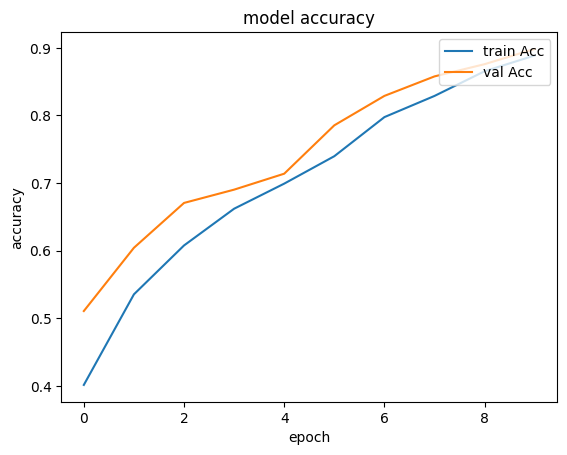

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train Acc', 'val Acc'], loc='upper right')
plt.show()

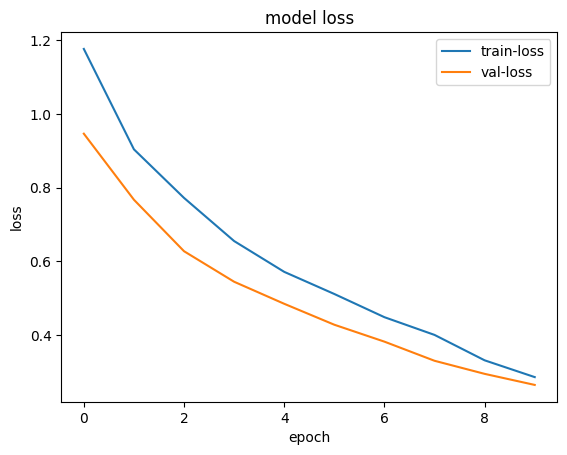

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train-loss', 'val-loss'], loc='upper right')
plt.show()

In [ ]:
predictions = model.predict(x_val)
predictions

120/120 [==============================] - 1s 9ms/step


array([[3.6602502e-03, 9.9506974e-01, 1.2678943e-03, 2.0209270e-06],
       [6.9931835e-01, 1.3097302e-03, 2.9914558e-01, 2.2632578e-04],
       [6.2893808e-01, 1.6473996e-03, 3.6921045e-01, 2.0404349e-04],
       ...,
       [5.2247439e-03, 9.9353045e-01, 1.2411221e-03, 3.6185957e-06],
       [9.2264670e-01, 9.4689317e-03, 6.7037612e-02, 8.4665971e-04],
       [1.9279331e-01, 1.8016661e-02, 7.8877079e-01, 4.1931705e-04]],
      dtype=float32)

In [ ]:
Y_actual, Y_predict

(array([[0, 1, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        ...,
        [0, 1, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 1, 0]]),
 array([[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]))

In [ ]:
#cm = confusion_matrix(Y_actual, Y_predict)
from sklearn.metrics import multilabel_confusion_matrix
cm = multilabel_confusion_matrix(Y_actual, Y_predict)

In [ ]:
cm = np.array([[845,6,179,1], [2,935,2,0], [87,5,897,0],[0,0,0,854] ])
cm

array([[845,   6, 179,   1],
       [  2, 935,   2,   0],
       [ 87,   5, 897,   0],
       [  0,   0,   0, 854]])

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Define the class labels
class_names = ['AF', 'Normal', 'Other', 'Noise']

Confusion matrix, without normalization
[[845   6 179   1]
 [  2 935   2   0]
 [ 87   5 897   0]
 [  0   0   0 854]]


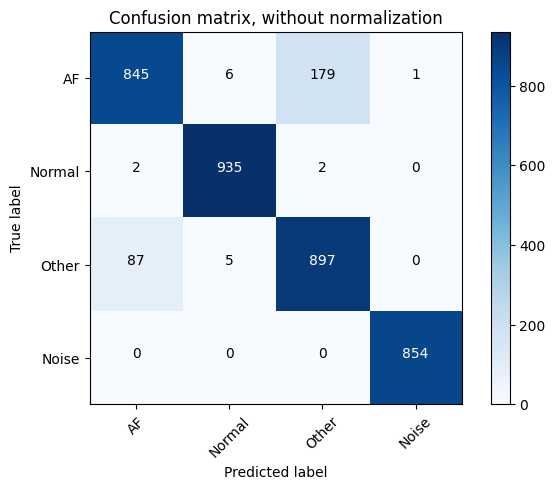

In [ ]:
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix, without normalization')

plt.show()